In [1]:
import glob, sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import glob
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
fft_size = 16777216
time_res = 64e-6 # in seconds
T_obs = (fft_size*time_res)/60 # in minutes is equal to 17.895 minutes
freq_axis = np.fft.rfftfreq(fft_size, d=64e-6)
freq_res = 1/(T_obs*60)

2023-06-08 19:17:22.687101: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
cur_dir = ''
run = 'runBB'
X_train = np.load(cur_dir + f'raw_data/{run}/train_data_chunk.npy').astype(np.float64)
X_test = np.load(cur_dir + f'raw_data/{run}/test_data_chunk.npy').astype(np.float64)
X_val = np.load(cur_dir + f'raw_data/{run}/val_data_chunk.npy').astype(np.float64)
X_train = X_train/np.max(X_train,axis=1)[:,None]
X_test = X_test/np.max(X_test,axis=1)[:,None]
X_val = X_val/np.max(X_val,axis=1)[:,None]

Y_train = np.load(cur_dir + f'raw_data/{run}/train_labels_chunk.npy').astype(np.float64)
Y_test = np.load(cur_dir + f'raw_data/{run}/test_labels_chunk.npy').astype(np.float64)
Y_val = np.load(cur_dir + f'raw_data/{run}/val_labels_chunk.npy').astype(np.float64)


# z_val = Y_val[:,1].copy()
# Y_val[:,0] = Y_val[:,0] - z_val
# Y_val[:,1] = Y_val[:,0] + z_val
# Y_val = np.sort(Y_val,axis=1)

# z_test = Y_test[:,1].copy()
# Y_test[:,0] = Y_test[:,0] - z_test
# Y_test[:,1] = Y_test[:,0] + z_test
# Y_test = np.sort(Y_test,axis=1)

# z_train = Y_train[:,1].copy()
# Y_train[:,0] = Y_train[:,0] - z_train
# Y_train[:,1] = Y_train[:,0] + z_train
# Y_train = np.sort(Y_train,axis=1)

Y_train[:,0] = np.abs(Y_train[:,0])
Y_test[:,0] = np.abs(Y_test[:,0])
Y_val[:,0] = np.abs(Y_val[:,0])

Y_train[:,1] = 2*np.abs(Y_train[:,1])
Y_test[:,1] = 2*np.abs(Y_test[:,1])
Y_val[:,1] = 2*np.abs(Y_val[:,1])

# # Y_train = Y_train/400
# # Y_test = Y_test/400
# # Y_val = Y_val/400

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1) 

# # Y_train = (Y_train.reshape(Y_train.shape[0],Y_train.shape[1], 1))
# # Y_val = (Y_val.reshape(Y_val.shape[0],Y_val.shape[1], 1))
# # Y_test = (Y_test.reshape(Y_test.shape[0],Y_test.shape[1], 1))

# Y_train = (Y_train.reshape(Y_train.shape[0],1))
# Y_val = (Y_val.reshape(Y_val.shape[0],1))
# Y_test = (Y_test.reshape(Y_test.shape[0],1))


In [4]:
test_indices = np.load(cur_dir + f'raw_data/{run}/test_indices.npy')
labels_df = pd.read_csv(cur_dir + f'meta_data/labels_{run}.csv')

In [34]:
def period_accuracy(Y_test, Y_pred):
    """
    Computes the percentage of predicted periods that are within 0.5% of the true periods.
    """
    accuracies = []
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    shape = Y_test.shape[1]
    for i in range(shape):
        rat = (Y_test[:,i]+ 1e-10)/(Y_pred[:,i]+ 1e-10)
        rat_bool = tf.logical_and(tf.less(rat, 1.005), tf.greater(rat, 0.995))
        accuracy = tf.reduce_mean(tf.cast(rat_bool, tf.float32)) * 100
        accuracies.append(accuracy)
    return [acc.numpy() for acc in accuracies]


def median_percent_deviation(Y_test, Y_pred):
    """
    Computes the median percent deviation from the predicted period.
    """
    Y_test = tf.cast(Y_test, tf.float32)
    Y_pred = tf.cast(Y_pred, tf.float32)
    median_deviations = []
    shape = Y_test.shape[1]
    for i in range(shape):
        
        Y_test_i = Y_test[:,i]
        Y_pred_i = Y_pred[:,i]

        percent_deviation = tf.abs((Y_test_i - Y_pred_i) / (Y_test_i + 1e-10)) * 100
        median_deviation = tfp.stats.percentile(percent_deviation, q=50)
        median_deviations.append(median_deviation)

    return [med.numpy() for med in median_deviations]


In [7]:
# Load the best model after training
best_modelf = tf.keras.models.load_model("models/f_predict_cnn_1115202_checkpoint.h5")
best_modelz = tf.keras.models.load_model("models/f_predict_attention_1115199_checkpoint.h5")

2023-06-08 18:39:55.033071: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-06-08 18:39:55.034343: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-06-08 18:39:55.558529: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-08 18:39:55.558623: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hercules12): /proc/driver/nvidia/version does not exist
2023-06-08 18:39:55.560213: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler

In [8]:
z_pred = best_modelz.predict(X_test)
f_pred = best_modelf.predict(X_test)

2023-06-08 18:40:02.895137: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-06-08 18:40:02.895625: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz


In [35]:
Y_pred = np.concatenate((f_pred,z_pred),axis=1)

In [36]:
accuracy = period_accuracy(Y_test, Y_pred)
median = median_percent_deviation(Y_test, Y_pred)
print("Period accuracy: ", accuracy)
print("Median percent deviation: ", median)

Period accuracy:  [88.5, 70.0]
Median percent deviation:  [0.13269605, 0.3049891]


In [37]:
for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    chunk_index = labels_df.loc[ind,'chunk_start']
    freq = chunk_index + Y_pred[i,0]
    #freq2 = chunk_index + Y_test[i,1]
    labels_df.at[ind,'p_pred'] = 1/(freq*freq_res)
    # if freq1 < freq2:
    #     labels_df.at[ind,'pred_freq_index0'] = freq1
    #     labels_df.at[ind,'pred_freq_index1'] = freq2

In [38]:
for i in range(Y_test.shape[0]):
    ind = test_indices[i]
    z = labels_df.loc[ind,'z']
    if z > 0:
       labels_df.at[ind,'z_pred'] = Y_pred[i,1]/2
    else:
        labels_df.at[ind,'z_pred'] = -Y_pred[i,1]/2 


In [40]:
labels_df_filtered = labels_df[~labels_df['p_pred'].isna()]

0.06282209544157902


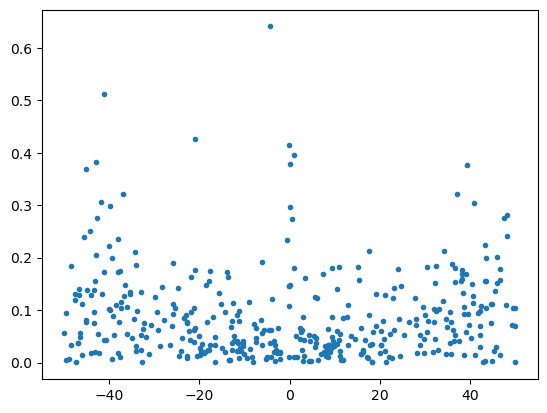

In [43]:
plt.plot(labels_df_filtered['z'],np.abs(labels_df_filtered['z_pred'] - labels_df_filtered['z']),'.')
print(np.median(np.abs(labels_df_filtered['z_pred'] - labels_df_filtered['z'])))

3.86545332435248e-08


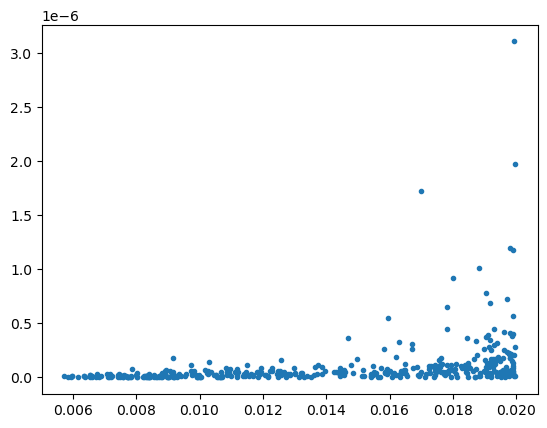

In [46]:
plt.plot(labels_df_filtered['period'],np.abs(labels_df_filtered['p_middle'] - labels_df_filtered['p_pred']),'.')
print(np.median(np.abs(labels_df_filtered['p_middle'] - labels_df_filtered['p_pred'])))

In [47]:
labels_df.to_csv('meta_data/labels_runBB.csv',index=False)

In [5]:
run = 'runBB'
files_list_temp = glob.glob(f'/hercules/results/atya/BinaryML/sims/{run}/fold_output_pred/*pfd.bestprof')
list_dicts_temp = []

for i in range(len(files_list_temp)):
    file = files_list_temp[i]
    with open(file, 'r') as file:
        data_dict = {}
        for line in file:
            # Remove any new line characters
            line = line.strip()

            # Skip empty lines or comment lines
            if not line:
                continue
            if '###############################' in line:
                break
            # Split the line by the '=' character

            key,value = re.split('=|>|<', line)

            #key, value = line.split('=|>|<')

            # Remove any leading or trailing whitespace
            key = key.strip()[2:]
            value = value.strip()

            # Add the key-value pair to the dictionary
            data_dict[key] = value
        list_dicts_temp.append(data_dict)

In [6]:
for item in list_dicts_temp:
    temp = item['Prob(Noise)']
    temp_list = temp.split(' ')
    item['prob'] = float(temp_list[0])
    item['noise'] = float(temp_list[3][2:])
    temp_p = item['P_topo (ms)']
    item['p_presto']= float(temp_p.split('+/-')[0])
    temp_pd = item["P'_topo (s/s)"]
    item['pd_presto'] = float(temp_pd.split('+/-')[0])

In [7]:
for dic in list_dicts_temp:
    file_name = dic['Input file']
    if file_name in labels_df['file_name'].values:
        labels_df.loc[labels_df['file_name']==file_name,'fold_snr_pred'] = dic['noise']
        labels_df.loc[labels_df['file_name']==file_name,'p_pred_from_bestprof'] = dic['p_presto']/1000
        labels_df.loc[labels_df['file_name']==file_name,'pd_pred_from_bestprof'] = dic['pd_presto']

In [8]:
labels_df.to_csv('meta_data/labels_runBB.csv',index=False)

In [10]:
labels_df.columns

Index(['# ind', 'period', 'snr', 'width', 'bper', 'binc', 'bcmass', 'bphase',
       'status', 'a', 'p_middle', 'pd', 'z', 'a_max', 'z_max', 'p_fold',
       'file_name', 'asini', 'periastron_time_mjd', 'fold_snr_theory',
       'fold_snr_true', 'p_true', 'pd_true', 'fold_snr_presto', 'p_presto',
       'pd_presto', 'chunk_start', 'p_pred', 'z_pred', 'a_pred', 'pd_pred',
       'p_fold_pred', 'fold_snr_pred', 'p_pred_from_bestprof',
       'pd_pred_from_bestprof'],
      dtype='object')